## Carga datos

In [11]:
import pandas as pd
import kglab

In [67]:
NAMESPACES = {
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "recipe":  "https://www.food.com/recipe/",
    
    "crime": "http://localhost/ontology2#",
    "cube": "http://purl.org/linked-data/cube#",
    "geo": "http://www.w3.org/2003/01/geo/wgs84_pos#",
    "ontology": "http://dbpedia.org/ontology/",
    "owl": "http://www.w3.org/2002/07/owl#",
    "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    "xsd": "http://www.w3.org/2001/XMLSchema#"
    }

kg = kglab.KnowledgeGraph(namespaces = NAMESPACES)

_ = kg.load_rdf("data/testind.ttl")

## Algunas metricas

In [68]:
measure = kglab.Measure()
measure.measure_graph(kg)

f"Nodes: {measure.get_node_count()} ; Edges: {measure.get_edge_count()}"

'Nodes: 17363 ; Edges: 156163'

In [ ]:
measure.p_gen.get_tally() # tallies the counts of predicates

In [ ]:
measure.s_gen.get_tally()[:20] # tallies the counts of predicates

In [ ]:
measure.o_gen.get_tally() # tallies the counts of predicates

In [ ]:
measure.l_gen.get_tally() # tallies the counts of literals

## KG como tensor

In [69]:
sg = kglab.SubgraphTensor(kg)

In [70]:
def to_edge_list(g, sg, excludes):
    def exclude(rel):
        return sg.n3fy(rel) in excludes
    
    relations = sorted(set(g.predicates()))
    subjects = set(g.subjects())
    objects = set(g.objects())
    nodes = list(subjects.union(objects))
    
    relations_dict = {rel: i for i, rel in enumerate(list(relations)) if not exclude(rel)}
    
    # this offset enables consecutive indices in our final vector
    offset = len(relations_dict.keys())
    
    nodes_dict = {node: i+offset for i, node in enumerate(nodes)}

    
    edge_list = []
    
    for s, p, o in g.triples((None, None, None)):
        if p in relations_dict.keys(): # this means is not excluded
            src, dst, rel = nodes_dict[s], nodes_dict[o], relations_dict[p]
            edge_list.append([src, dst, 2 * rel])
            edge_list.append([dst, src, 2 * rel + 1])
    
    # turn into str keys and concat
    node_vector = [sg.n3fy(node) for node in relations_dict.keys()] + [sg.n3fy(node) for node in nodes_dict.keys()]
    return edge_list, node_vector

In [304]:
edge_list, node_vector = to_edge_list(kg.rdf_graph(), sg, excludes=['skos:description', 'skos:prefLabel'])

In [305]:
len(edge_list) , edge_list[0:5]

(312326,
 [[6370, 52737, 14],
  [52737, 6370, 15],
  [28140, 50158, 10],
  [50158, 28140, 11],
  [45013, 54135, 38]])

#### Subgrafo para codificar/decodificar ids y uri. Necesario para preparar dataset de entrenamiento y útil para darle sentido a los resultados de la red neuronal

In [306]:
sg = kglab.Subgraph(kg=kg, preload=node_vector)

In [307]:
import torch
from torch_geometric.data import Data

tensor = torch.tensor(edge_list, dtype=torch.long).t().contiguous() 
edge_index, edge_type = tensor[:2], tensor[2]
data = Data(edge_index=edge_index)
data.edge_type = edge_type

In [308]:
(data.edge_index.shape, data.edge_type.shape, data.edge_type.max())

(torch.Size([2, 312326]), torch.Size([312326]), tensor(39))

In [132]:
# LABELS = [
# "http://localhost/VIOLENCIA_FAMILIAR"
# "http://localhost/ROBO_DE_OBJETOS"
# "http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENCIA"
# "http://localhost/AMENAZAS"
# "http://localhost/DENUNCIA_DE_HECHOS"
# "http://localhost/FRAUDE"
# "http://localhost/ROBO_A_TRANSEUNTE_EN_VIA_PUBLICA_CON_VIOLENCIA"
# "http://localhost/ROBO_DE_VEHICULO_DE_SERVICIO_PARTICULAR_SIN_VIOLENCIA"
# "http://localhost/ROBO_A_CASA_HABITACION_SIN_VIOLENCIA"
# "http://localhost/FALSIFICACION_DE_TITULOS_AL_PORTADOR_Y_DOCUMENTOS_DE_CREDITO_PUBLICO"
# "http://localhost/ROBO_DE_OBJETOS_DEL_INTERIOR_DE_UN_VEHICULO"
# "http://localhost/ROBO_DE_ACCESORIOS_DE_AUTO"
# "http://localhost/DAÑO_EN_PROPIEDAD_AJENA_CULPOSA_POR_TRÁNSITO_VEHICULAR_A_AUTOMOVIL"
# "http://localhost/ROBO_A_TRANSEUNTE_DE_CELULAR_CON_VIOLENCIA"
# "http://localhost/ROBO_A_TRANSEUNTE_DE_CELULAR_SIN_VIOLENCIA"
# "http://localhost/DESPOJO"
# "http://localhost/ABUSO_DE_CONFIANZA"
# "http://localhost/LESIONES_CULPOSAS_POR_TRANSITO_VEHICULAR_EN_COLISION"
# "http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA"
# "http://localhost/LESIONES_INTENCIONALES_POR_GOLPES"
# ]



### Preparación de dataset "crudo" de ~recetas~ e ~ingredientes~

In [76]:
# De acuerdo a los datos, deberiamos abordar la clasificación de ¿¿??
# desde el punto de vista de las denuncias o de los crímenes. 

# A clasificar: crime:tieneCategoria
# Atributo: crime:contiene

import pandas as pd
sparql = """
    SELECT distinct *
    WHERE {
        ?uri a crime:Denuncia .
        ?uri a ?type .
        ?uri crime:sucedio ?definition .
        # Necesitaremos encadenar las colonias para extraer mas info?
        # ?uri crime:ocurrioEn ?lugar
        
        # ?uri crime:tieneCategoria ?atributo
        ?uri crime:contiene ?atributo
        
    }
"""
# Agregar tiene categoria como "ingrediente" o intentar ?lugar como ingrediente
# Cabe la posibilidad de usar "crime:tieneCategoria" en vez de "crime:denuncia"

df = kg.query_as_df(sparql=sparql)

# We group the ingredients into one column containing lists:
denuncias_df = df.groupby(['uri', 'definition', 'type'])['atributo'].apply(list).reset_index(name='atributo')

# si utilizamos categoria, tenemos información de horas y coordenadas
sparql_serializado = """
    SELECT distinct *
    WHERE {
        # ?uri a crime:tieneCategoria .

        ?uri a crime:Delito .
        ?uri a ?type .
        # OPTIONAL { ?uri crime:ocurrioEn ?definition } 
        OPTIONAL { ?uri crime:tieneCategoria ?definition } 
    }
"""

type_crime_df = kg.query_as_df(sparql=sparql_serializado)
type_crime_df['atributo'] = None

crimes_df = pd.concat([denuncias_df, type_crime_df]).reset_index(drop=True)

crimes_df.fillna('', inplace=True) ; crimes_df

,uri,definition,type,atributo
0,<http://localhost/10001>,2016-10-05 12:30:00,crime:Denuncia,[<http://localhost/AMENAZAS>]
1,<http://localhost/10001>,2016-10-05 12:30:00,crime:obs,[<http://localhost/AMENAZAS>]
2,<http://localhost/100027>,2016-03-01 12:30:00,crime:Denuncia,[<http://localhost/ROBO_DE_OBJETOS>]
3,<http://localhost/100027>,2016-03-01 12:30:00,crime:obs,[<http://localhost/ROBO_DE_OBJETOS>]
4,<http://localhost/100045>,2016-03-17 18:40:00,crime:Denuncia,[<http://localhost/ROBO_DE_OBJETOS>]
...,...,...,...,...
20025,<http://localhost/FRAUDE>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,crime:Delito,
20026,<http://localhost/DENUNCIA_DE_HECHOS>,<http://localhost/HECHO_NO_DELICTIVO>,crime:Delito,
20027,<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENCIA>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,crime:Delito,
20028,<http://localhost/ROBO_DE_OBJETOS>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,crime:Delito,


In [77]:
## EXTRA: Necesitamos este "type" extra? --> crime:obs
# Antes
crimes_df.shape # (20030, 4)

(20030, 4)

In [136]:
valid_rows = crimes_df["type"] != "crime:obs"
crimes_df = crimes_df[valid_rows]


In [137]:
# Después
crimes_df.shape # (10030, 4)

(10030, 4)

In [46]:
LABELS = list(df['definition'].unique())

In [138]:
LABELS = [float('nan'),
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
 '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/HECHO_NO_DELICTIVO>']

LABELS

[nan,
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
 '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/HECHO_NO_DELICTIVO>']

### Se guarda el proceso de la manipulación de datos en un CSV de ambos datasets

In [139]:
# Se quitan las filas repetidas --> crime:obs & crime:Denuncia
valid_rows = denuncias_df["type"] != "crime:obs"
denuncias_df = denuncias_df[valid_rows]
denuncias_df.to_csv("data/denuncias_raw.csv")

In [140]:
type_crime_df.to_csv("data/type_crime_raw.csv")

### Se guarda el dataset consolidado de denuncias y crímenes

In [141]:
crimes_df.to_csv("data/graph_to_table.csv")

### CHECKPOINT #1: Se carga el CSV con puras denuncias para solo el etiquetado que después se usará en el model de aprendizaje supervisado. ESTO TIENE QUE SER LLEVADO A CABO DE OTRA FORMA

In [212]:
denuncias_df = pd.read_csv("data/denuncias_raw.csv")
type_crime_df = pd.read_csv("data/type_crime_raw.csv")

In [213]:
denuncias_df.head(3)

,Unnamed: 0,uri,definition,type,atributo
0,0,<http://localhost/10001>,2016-10-05 12:30:00,crime:Denuncia,['<http://localhost/AMENAZAS>']
1,2,<http://localhost/100027>,2016-03-01 12:30:00,crime:Denuncia,['<http://localhost/ROBO_DE_OBJETOS>']
2,4,<http://localhost/100045>,2016-03-17 18:40:00,crime:Denuncia,['<http://localhost/ROBO_DE_OBJETOS>']


In [214]:
type_crime_df.head(3)

,Unnamed: 0,type,uri,definition,atributo
0,0,crime:Delito,crime:Violencia_familiar,NaN,NaN
1,1,owl:NamedIndividual,crime:Violencia_familiar,NaN,NaN
2,2,crime:Delito,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_M...,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_...,NaN


### Con el fin de etiquetar el dataset de denuncias y por cuestiones prácticas, se hace un join entre la tabla de denuncias y la de crimenes para asignarle una categoría. OTRA VEZ, ESTO TIENE QUE HACERSE DE OTRA FORMA

In [215]:
# Se extraen el unico atributo para dejarlo como un string y no como una lista de strings 
denuncias_df["atributo"] = denuncias_df["atributo"].apply(lambda x: x.split("'")[1])

In [216]:
denuncias_labeled = pd.merge(denuncias_df, type_crime_df[["uri", "definition"]], left_on="atributo", right_on="uri", how='left')

In [217]:
del denuncias_labeled["uri_y"]

In [218]:
# se renombran las columnas necesarias
denuncias_labeled = denuncias_labeled.rename(
    columns={
        "uri_x": "uri",
        "definition_x": "definition",
        "definition_y": "labels"
    })

In [219]:
denuncias_labeled.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
0,0,<http://localhost/10001>,2016-10-05 12:30:00,crime:Denuncia,<http://localhost/AMENAZAS>,<http://localhost/DELITO_DE_BAJO_IMPACTO>
1,2,<http://localhost/100027>,2016-03-01 12:30:00,crime:Denuncia,<http://localhost/ROBO_DE_OBJETOS>,<http://localhost/DELITO_DE_BAJO_IMPACTO>
2,4,<http://localhost/100045>,2016-03-17 18:40:00,crime:Denuncia,<http://localhost/ROBO_DE_OBJETOS>,<http://localhost/DELITO_DE_BAJO_IMPACTO>


In [220]:
# Convirtiendo nuevamente las "labels" como una lista
denuncias_labeled["labels"] = denuncias_labeled["labels"].apply(lambda x: [f"{x}"])

In [221]:
# Se splitea el dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(denuncias_labeled)

### Con el fines lúdicos, se le asgina como vacío a la columna de labels del DATASET DE PRUEBA.
#### Cambio: El ejercicio de las recetas sí usa las etiquetas en el dataset de prueba

In [222]:
# test_df["labels"] = None

In [223]:
# train_df.head(3)

In [224]:
# test_df.head(3)

In [225]:
# Se guardan los datasets
train_df.to_csv("data/train_tables.csv")
test_df.to_csv("data/test_table.csv")

In [226]:
df = pd.read_csv("data/graph_to_table.csv")

In [227]:
# # ESTO NO ES NECESARIO PARA NUESTRO EJERCICIO PUESTO QUE SE TIENE QUE HACEER UNA LABOR
# # DE ETIQUETADO POR LO QUE NO EL GUARDARLO Y CARGARLO SIN ETIQUETAS ES INÚTIL.
# USAR data/train_tables.csv Y data/test_tables.csv

# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df)
# train_df.to_csv('data/train_table_new.csv')
# test_df.to_csv('data/test_table_new.csv')

## Checkpoint 2: Se cargan los dataset YA etiquetados

In [78]:
train_df = pd.read_csv('data/train_tables.csv') # use your own labelled datasets if you've created a snapshot
test_df = pd.read_csv('data/test_table.csv')

train_df.labels = train_df.labels.apply(eval)
test_df.labels = test_df.labels.apply(eval)

In [79]:
train_df.head()

,Unnamed: 0,Unnamed: 0.1,uri,definition,type,atributo,labels
0,309,618,<http://localhost/104066>,2016-09-03 22:00:00,crime:Denuncia,<http://localhost/VIOLENCIA_FAMILIAR>,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
1,7426,14644,<http://localhost/64806>,2016-08-23 11:30:00,crime:Denuncia,<http://localhost/USURPACIÓN_DE_IDENTIDAD>,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
2,1123,2218,<http://localhost/114573>,2016-02-11 14:15:00,crime:Denuncia,<http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENCIA>,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
3,7944,15680,<http://localhost/71867>,2016-07-07 01:00:00,crime:Denuncia,<http://localhost/ROBO_A_CASA_HABITACION_SIN_V...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
4,6574,12968,<http://localhost/54218>,2016-11-12 16:00:00,crime:Denuncia,<http://localhost/ROBO_A_CASA_HABITACION_SIN_V...,[<http://localhost/DELITO_DE_BAJO_IMPACTO>]


### Let's create label lookups for label to int and viceversa

In [80]:
# Labels from previous analysis
LABELS = [float('nan'),
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
 '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/HECHO_NO_DELICTIVO>']

In [81]:
label2id = {label:i for i,label in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()} ; (id2label, label2id)

({0: nan,
  1: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
  2: '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  3: '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
  4: '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
  5: '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
  6: '<http://localhost/HECHO_NO_DELICTIVO>'},
 {nan: 0,
  '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>': 1,
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>': 2,
  '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>': 3,
  '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>': 4,
  '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>': 5,
  '<http://localhost/HECHO_NO_DELICTIVO>': 6})

### The following function turns our DataFrame into numerical arrays for node indices and labels

In [82]:
import torch
from torch_geometric.data import Data
import numpy as np

def create_indices_labels(df):
    # turn our dense labels into a one-hot list
    def one_hot(label_ids):
        a = np.zeros(len(LABELS))
        a.put(label_ids, np.ones(len(label_ids)))
        return a
    
    indices, labels = [], []
    for uri, label in zip(df.uri.tolist(), df.labels.tolist()):
        indices.append(sg.transform(uri))
        labels.append(one_hot([label2id[label] for label in label]))
    return indices, labels

In [83]:
train_indices, train_labels = create_indices_labels(train_df)
test_indices, test_labels = create_indices_labels(test_df)

train_idx = torch.tensor(train_indices, dtype=torch.long)
train_y = torch.tensor(train_labels, dtype=torch.float)

test_idx = torch.tensor(test_indices, dtype=torch.long)
test_y = torch.tensor(test_labels, dtype=torch.float) ; train_idx[:10], train_y

(tensor([46347, 11504, 29970, 23332, 22611, 42935, 22808, 32111, 39240, 21661]),
 tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]))

In [84]:
(train_df.loc[0], sg.inverse_transform(41508))

(Unnamed: 0                                              309
 Unnamed: 0.1                                            618
 uri                               <http://localhost/104066>
 definition                              2016-09-03 22:00:00
 type                                         crime:Denuncia
 atributo              <http://localhost/VIOLENCIA_FAMILIAR>
 labels          [<http://localhost/DELITO_DE_BAJO_IMPACTO>]
 Name: 0, dtype: object,
 '19.4292099998,-99.091345')

## Creando un subgrafo de nodos para "recetas" e "ingredientes"

In [85]:
node_idx = torch.LongTensor([
    sg.transform(i) for i in crimes_df.uri.values
])

In [86]:
node_idx.max(), node_idx.shape

(tensor(54186), torch.Size([20030]))

In [87]:
crimes_df.iloc[1]

uri                <http://localhost/10001>
definition              2016-10-05 12:30:00
type                              crime:obs
atributo      [<http://localhost/AMENAZAS>]
Name: 1, dtype: object

In [88]:
sg.inverse_transform(node_idx[1])

'<http://localhost/10001>'

In [57]:
node_idx[0:10]

tensor([25035, 25035,  8906,  8906, 11086, 11086, 30678, 30678, 53654, 53654])

## Clasificación semi-supervisada

In [385]:
from torch_geometric.utils import k_hop_subgraph
# here we take all connected nodes with k hops
k = 10
# The method returns 
# (1) the nodes involved in the subgraph,
# (2) the filtered edge_index connectivity, 
# (3) the mapping from node indices in node_idx to their new location, and 
# (4) the edge mask indicating which edges were preserved.
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 
    k, 
    data.edge_index, 
    relabel_nodes=False
)

In [246]:
removed_nodes_indx = []
for m, preserved_node in enumerate(edge_mask):
    if not preserved_node:
        # print(m, preserved_node)
        removed_nodes_indx.append(m)
removed_nodes_indx

[60786, 60787, 127044, 127045]

In [386]:
# Let's use another tensor
data_removed_nodes_by_subgraph = data.clone()

In [387]:
shape_graph = data_removed_nodes_by_subgraph.edge_index.shape

In [388]:
shape_graph

torch.Size([2, 312326])

In [389]:
edge_mask_reshaped = edge_mask.repeat(shape_graph[0], 1)

In [390]:
# reshape according with data returned by the k_hops model
# edge_index
data_removed_nodes_by_subgraph.edge_index = data_removed_nodes_by_subgraph.edge_index[edge_mask_reshaped].view(edge_index.shape)
data_removed_nodes_by_subgraph.edge_type = data_removed_nodes_by_subgraph.edge_type[edge_mask]

In [391]:
data_removed_nodes_by_subgraph

Data(edge_index=[2, 312322], edge_type=[312322])

In [393]:
edge_index.shape # SHALL WE REMOVE THE UNLINKED NODES? a: YES --> Remove them using edge_mask object

torch.Size([2, 312322])

In [394]:
node_idx.shape

torch.Size([54170])

In [397]:
## Algunas metricas para el modelo
data_removed_nodes_by_subgraph.edge_index = edge_index

data_removed_nodes_by_subgraph.num_nodes = data_removed_nodes_by_subgraph.edge_index.max().item() + 1

data_removed_nodes_by_subgraph.num_relations = data_removed_nodes_by_subgraph.edge_type.max().item() + 1

# This is already done by our process
# data_removed_nodes_by_subgraph.edge_type = data_removed_nodes_by_subgraph.edge_type[edge_mask]

data_removed_nodes_by_subgraph.num_classes = len(LABELS)

data_removed_nodes_by_subgraph.num_nodes, data_removed_nodes_by_subgraph.num_relations, data_removed_nodes_by_subgraph.num_classes

(54193, 40, 7)

### Definición de una RGCN

In [377]:
from torch_geometric.nn import FastRGCNConv, RGCNConv
import torch.nn.functional as F

In [378]:
class RGCN(torch.nn.Module):
    def __init__(self, num_nodes, num_relations, num_classes, out_channels=16, num_bases=30, dropout=0.0, layer_type=FastRGCNConv, ):
        
        super(RGCN, self).__init__()
        
        self.conv1 = layer_type(
            num_nodes, 
            out_channels, 
            num_relations, 
            num_bases=num_bases
        )
        self.conv2 = layer_type(
            out_channels, 
            num_classes, 
            num_relations, 
            num_bases=num_bases
        )
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_type)
        return torch.sigmoid(x)

### Visualización del modelo

In [398]:
model = RGCN(
    num_nodes=data_removed_nodes_by_subgraph.num_nodes,
    num_relations=data_removed_nodes_by_subgraph.num_relations,
    num_classes=data_removed_nodes_by_subgraph.num_classes,
    #out_channels=64,
    dropout=0.2,
    layer_type=RGCNConv
) ; model

RGCN(
  (conv1): RGCNConv(54193, 16, num_relations=40)
  (conv2): RGCNConv(16, 7, num_relations=40)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [399]:
# code adapted from https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pytorch_lightning.metrics.utils import to_categorical

def visualize(h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    legend = plt.legend(scatter.legend_elements()[0],labels, loc="upper right", title="Labels",) #*scatter.legend_elements()
    plt.show()

In [400]:
edge_index.shape

torch.Size([2, 312322])

In [401]:
edge_type.shape

torch.Size([312326])

In [403]:
edge_type[edge_mask].shape

torch.Size([312322])

In [404]:
# pred = model(edge_index, edge_type)
pred = model(edge_index, edge_type[edge_mask])

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


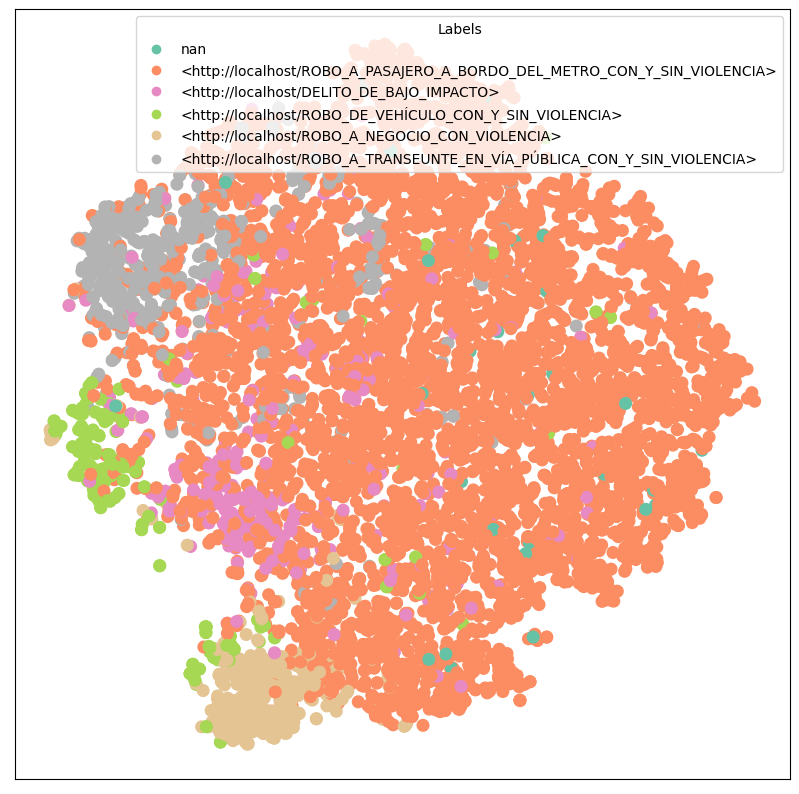

In [405]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)
# visualize(pred[train_idx], labels=LABELS)

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


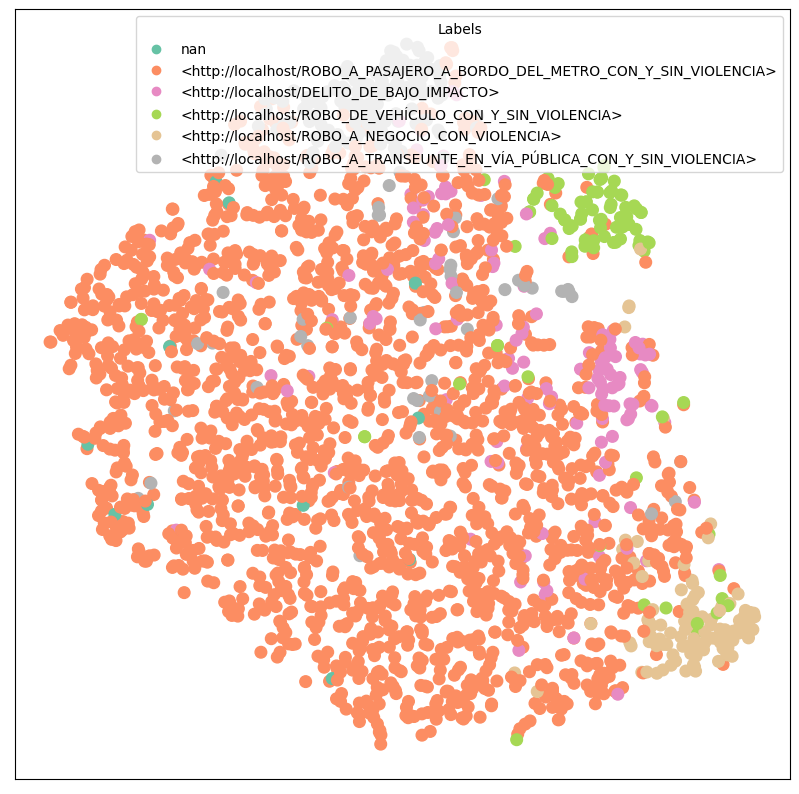

In [406]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)

### Entrena la RGCN

In [410]:
device = torch.device('cpu') # ('cuda')
data_device = data_removed_nodes_by_subgraph.to(device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters())
loss_module = torch.nn.BCELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_device.edge_index, data_device.edge_type)
    loss = loss_module(out[train_idx], train_y)
    loss.backward()
    optimizer.step()
    return loss.item()

def accuracy(predictions, y):
    predictions = np.round(predictions)
    return predictions.eq(y).to(torch.float).mean()

@torch.no_grad()
def test():
    model.eval()
    pred = model(data_device.edge_index, data_device.edge_type)
    train_acc = accuracy(pred[train_idx], train_y)
    test_acc = accuracy(pred[test_idx], test_y)
    return train_acc.item(), test_acc.item()

In [409]:
for epoch in range(1, 50):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.6913, Train: 0.9603 Test: 0.9577
Epoch: 02, Loss: 0.6651, Train: 0.9659 Test: 0.9652
Epoch: 03, Loss: 0.6412, Train: 0.9676 Test: 0.9682
Epoch: 04, Loss: 0.6131, Train: 0.9678 Test: 0.9679
Epoch: 05, Loss: 0.5868, Train: 0.9681 Test: 0.9674
Epoch: 06, Loss: 0.5577, Train: 0.9673 Test: 0.9653
Epoch: 07, Loss: 0.5332, Train: 0.9653 Test: 0.9633
Epoch: 08, Loss: 0.4986, Train: 0.9638 Test: 0.9620
Epoch: 09, Loss: 0.4571, Train: 0.9635 Test: 0.9605
Epoch: 10, Loss: 0.4274, Train: 0.9632 Test: 0.9592
Epoch: 11, Loss: 0.4173, Train: 0.9635 Test: 0.9595
Epoch: 12, Loss: 0.3708, Train: 0.9631 Test: 0.9604
Epoch: 13, Loss: 0.3406, Train: 0.9621 Test: 0.9608
Epoch: 14, Loss: 0.3310, Train: 0.9615 Test: 0.9609
Epoch: 15, Loss: 0.3003, Train: 0.9615 Test: 0.9613
Epoch: 16, Loss: 0.2733, Train: 0.9615 Test: 0.9615
Epoch: 17, Loss: 0.2435, Train: 0.9615 Test: 0.9616
Epoch: 18, Loss: 0.2469, Train: 0.9616 Test: 0.9615
Epoch: 19, Loss: 0.2019, Train: 0.9616 Test: 0.9612
Epoch: 20, L

In [411]:
for epoch in range(1, 50):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.0241, Train: 0.9999 Test: 0.9929
Epoch: 02, Loss: 0.0248, Train: 1.0000 Test: 0.9962
Epoch: 03, Loss: 0.0280, Train: 1.0000 Test: 0.9971
Epoch: 04, Loss: 0.0222, Train: 1.0000 Test: 0.9975
Epoch: 05, Loss: 0.0158, Train: 1.0000 Test: 0.9978
Epoch: 06, Loss: 0.0126, Train: 1.0000 Test: 0.9983
Epoch: 07, Loss: 0.0110, Train: 1.0000 Test: 0.9984
Epoch: 08, Loss: 0.0141, Train: 1.0000 Test: 0.9987
Epoch: 09, Loss: 0.0090, Train: 1.0000 Test: 0.9992
Epoch: 10, Loss: 0.0070, Train: 1.0000 Test: 0.9994
Epoch: 11, Loss: 0.0075, Train: 1.0000 Test: 0.9996
Epoch: 12, Loss: 0.0133, Train: 1.0000 Test: 0.9996
Epoch: 13, Loss: 0.0084, Train: 1.0000 Test: 0.9997
Epoch: 14, Loss: 0.0062, Train: 1.0000 Test: 0.9998
Epoch: 15, Loss: 0.0112, Train: 1.0000 Test: 0.9998
Epoch: 16, Loss: 0.0040, Train: 1.0000 Test: 0.9999
Epoch: 17, Loss: 0.0099, Train: 1.0000 Test: 0.9999
Epoch: 18, Loss: 0.0068, Train: 1.0000 Test: 0.9999
Epoch: 19, Loss: 0.0052, Train: 1.0000 Test: 0.9999
Epoch: 20, L

### Model visualization

In [412]:
pred = model(edge_index, edge_type[edge_mask])

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


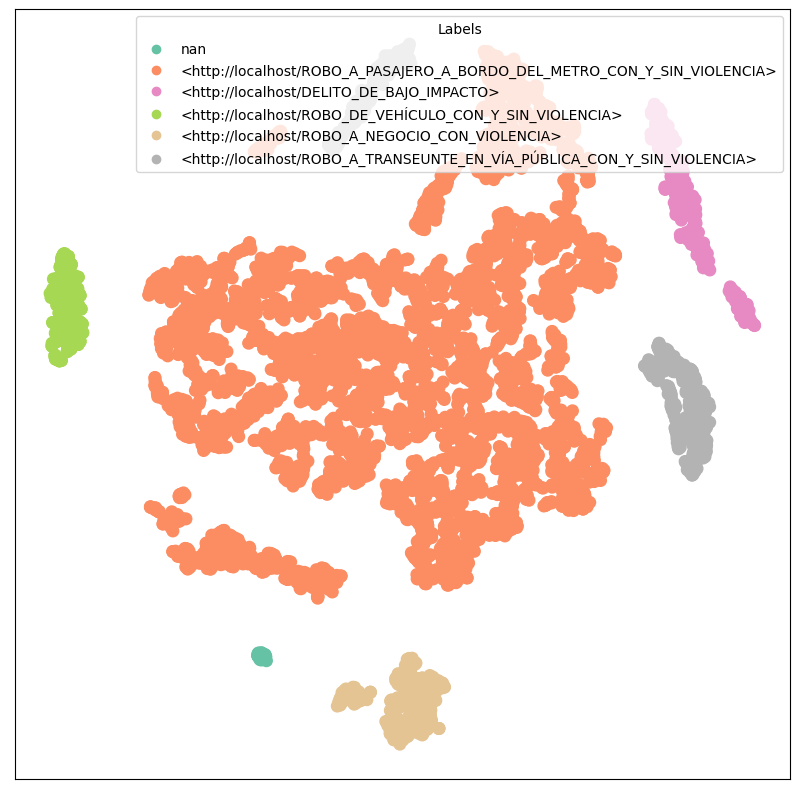

In [413]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


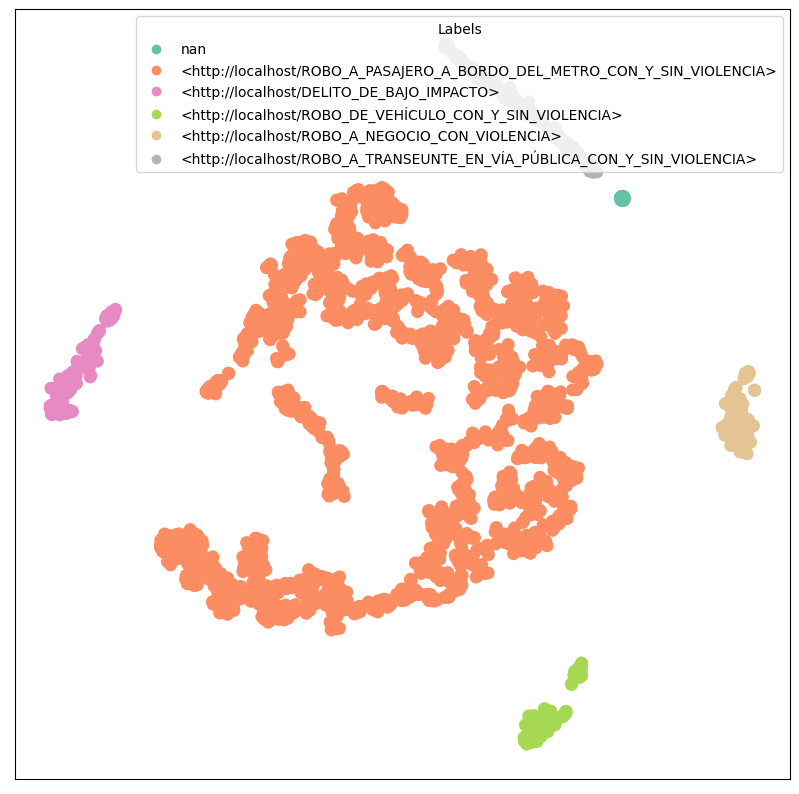

In [414]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)